In [28]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
plt.style.use('ggplot')

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
# CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 10
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2018


#print(calculate.cliffsD([1, 2, 3, 4, 5, 9], [1, 2, 5, 6, 7, 9]))

### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read authors with start and end year details

In [29]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')
# authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')
authorStartEndCareerData.head()

,author,start_year,end_year,num_pub,career_length,max_absence,avg_absence,dropped_after_10,gender,early_career_qual,early_career_recognition,succ_after_15y,early_career_prod
0,'maseka lesaoana,2001,2015,2,15,14,14.000000,True,none,23.0,5.0,23.0,1
1,a aart blokhuis,1992,2005,2,14,13,13.000000,True,none,0.0,0.0,0.0,1
2,a min tjoa,1979,2017,191,39,7,1.071429,False,none,0.0,0.0,2.0,1
3,a-imam al-sammak,1992,2006,3,15,13,7.000000,True,m,0.0,0.0,0.0,1
4,a-xing zhu,1998,2017,22,20,5,1.166667,False,none,0.0,0.0,38.0,1


### Read Citation data (uses paper->author network)

In [30]:
authorCitationsData = pd.read_csv('derived-data/authors-perYear-citations-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorCitationsData.rename(columns={'year_cit':'year', 'cit_count':'num_cit'}, inplace=True)

In [31]:
print(authorCitationsData.head(n=3))

# 'maseka lesaoana published 2 publications in total, one in 2001 and one in 2015
# for the one is 2015 she did not get yet any citations
print(authorCitationsData[authorCitationsData["author"] == '\'maseka lesaoana'])

# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
print(authorCitationsData[authorCitationsData["author"] == '(max) zong-ming cheng'])

# BUG: no zeros????
from collections import Counter
print(Counter(authorCitationsData["num_cit"]))

             author  year  num_cit
0  'maseka lesaoana  2002        1
1  'maseka lesaoana  2003        1
2  'maseka lesaoana  2004        1
              author  year  num_cit
0   'maseka lesaoana  2002        1
1   'maseka lesaoana  2003        1
2   'maseka lesaoana  2004        1
3   'maseka lesaoana  2005        2
4   'maseka lesaoana  2006        4
5   'maseka lesaoana  2007        1
6   'maseka lesaoana  2008        3
7   'maseka lesaoana  2009        1
8   'maseka lesaoana  2010        1
9   'maseka lesaoana  2012        1
10  'maseka lesaoana  2013        2
11  'maseka lesaoana  2015        5
12  'maseka lesaoana  2016        1
13  'maseka lesaoana  2017        1
Empty DataFrame
Columns: [author, year, num_cit]
Index: []
Counter({1: 637838, 2: 378025, 3: 259819, 4: 194592, 5: 153509, 6: 124368, 7: 103543, 8: 88083, 9: 76468, 10: 66861, 11: 58481, 12: 51956, 13: 46818, 14: 41847, 15: 38166, 16: 35143, 17: 32199, 18: 29339, 19: 27216, 20: 25220, 21: 23268, 22: 21693, 23: 20261, 2

### Merge citations with authors

In [32]:
authorCitationsData = authorCitationsData.merge(authorStartEndCareerData[['author', 'start_year', 'gender']], on='author')

In [33]:
print(authorCitationsData.head(n=3))

# 'maseka lesaoana published 2 publications in total, one in 2001 and one in 2015
# every year she got some citations
print(authorCitationsData[authorCitationsData["author"] == '\'maseka lesaoana'])
print(authorCitationsData[authorCitationsData["author"] == '\'maseka lesaoana'].shape)

# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
# in 2011 he received 0 citations and after 2013 as well!!!
print(authorCitationsData[authorCitationsData["author"] == '(max) zong-ming cheng'])

# BUG: no zeros????
from collections import Counter
print(Counter(authorCitationsData["num_cit"]))

             author  year  num_cit  start_year gender
0  'maseka lesaoana  2002        1        2001   none
1  'maseka lesaoana  2003        1        2001   none
2  'maseka lesaoana  2004        1        2001   none
              author  year  num_cit  start_year gender
0   'maseka lesaoana  2002        1        2001   none
1   'maseka lesaoana  2003        1        2001   none
2   'maseka lesaoana  2004        1        2001   none
3   'maseka lesaoana  2005        2        2001   none
4   'maseka lesaoana  2006        4        2001   none
5   'maseka lesaoana  2007        1        2001   none
6   'maseka lesaoana  2008        3        2001   none
7   'maseka lesaoana  2009        1        2001   none
8   'maseka lesaoana  2010        1        2001   none
9   'maseka lesaoana  2012        1        2001   none
10  'maseka lesaoana  2013        2        2001   none
11  'maseka lesaoana  2015        5        2001   none
12  'maseka lesaoana  2016        1        2001   none
13  'maseka le

### Citation distribution after 15 years

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


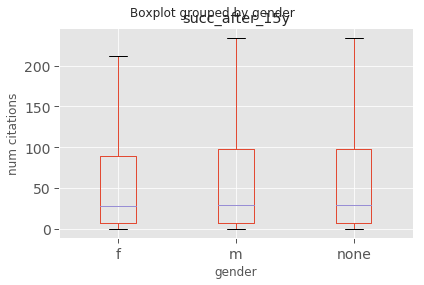

In [34]:
ax = authorStartEndCareerData.boxplot(column='succ_after_15y', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [35]:

groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorCitationsData, 1, 'num_cit')

In [36]:
years = authorCitationsData['year'].unique()
years = sorted(years)
print(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [37]:
from importlib import reload
reload(plot)

<module 'plot' from '/home/danielkostic/cumulative-advantage/plot.py'>

### Cohort Analysis (Num Cit)

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


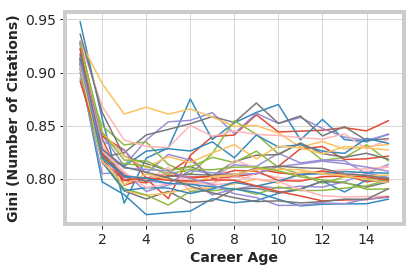

plot_cohort_size_gini_cor ---  unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


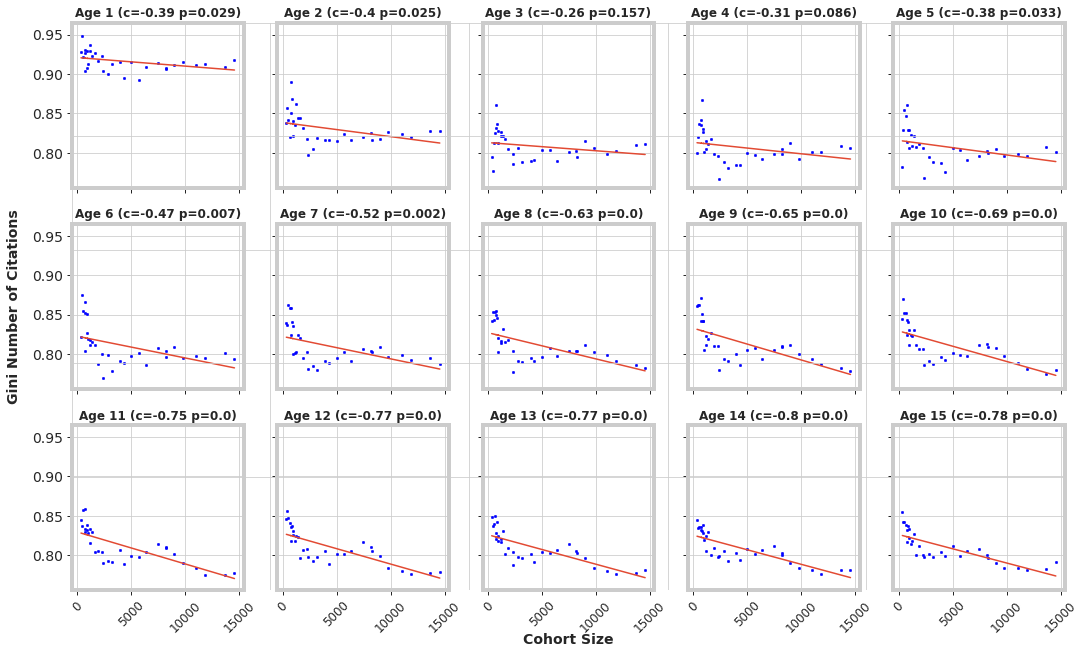

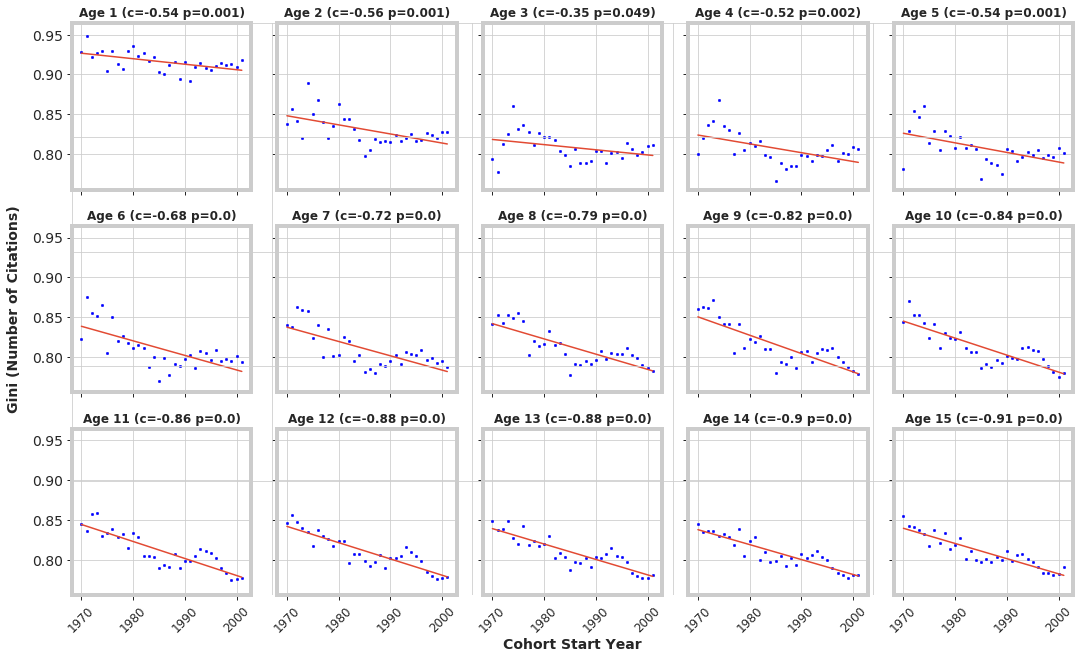

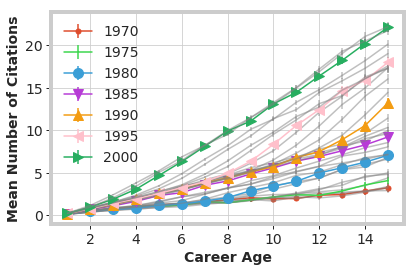

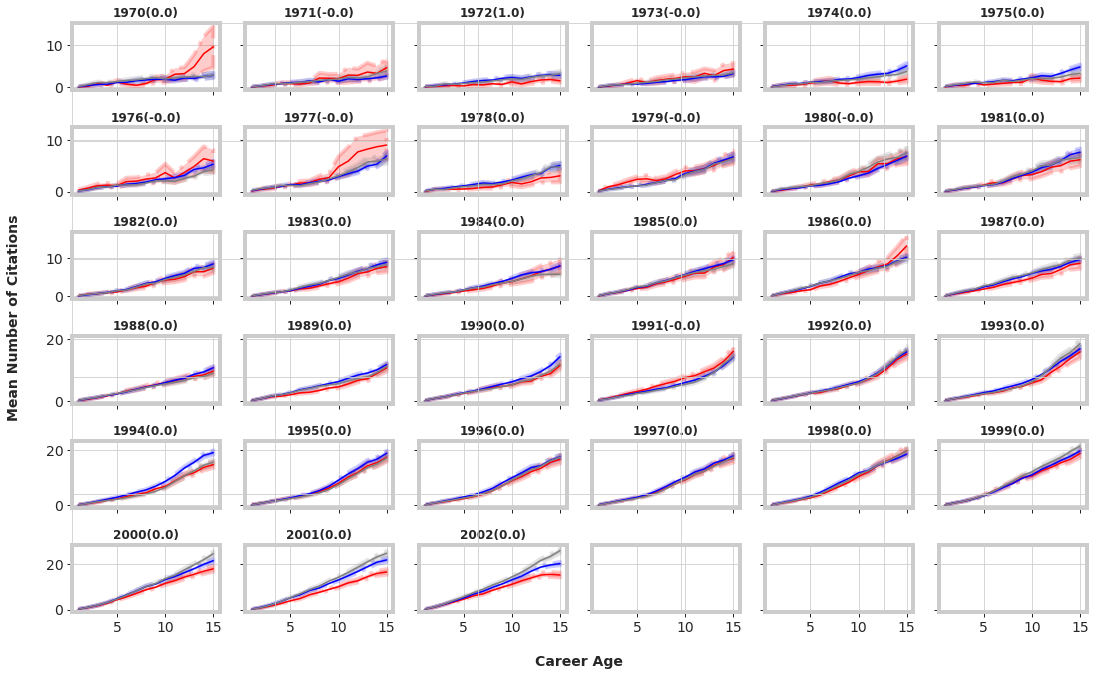

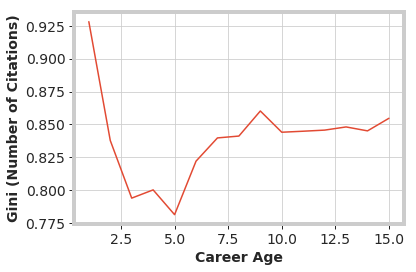

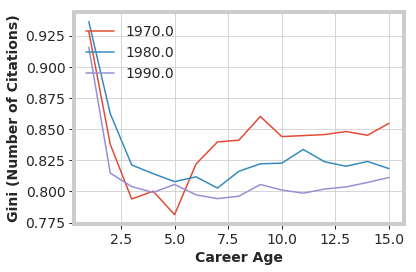

In [38]:
plot.run_cohort_analysis(authorCitationsData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_cit", "Number of Citations", authorStartEndCareerData)  

In [39]:
groupByYearData.head()

,year,author,num_cit,start_year,gender,cum_num_cit
0,1970,donald r. slutz,1,1970,m,1
1,1970,h. j. greenberg,2,1970,none,2
2,1970,mike paterson,2,1970,none,2
3,1970,irving l. traiger,1,1970,m,1
4,1970,ben wegbreit,4,1970,none,4


In [40]:
from importlib import reload
reload(plot)

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_cit", authorStartEndCareerData)

#------------------------------------------
# some plausibility checks
print(groupByYearData.head(n=1))
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))

# (max) zong-ming cheng published 2 publications in total, one in 2009 and one in 2012
# in 2011 he received 0 citations and after 2013 as well!!!
print(groupByYearData[groupByYearData["author"] == '(max) zong-ming cheng'])


subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))

   year           author  num_cit  start_year gender  cum_num_cit
0  1970  donald r. slutz        1        1970      m            1
         year            author  num_cit  start_year gender  cum_num_cit
569919   2002  'maseka lesaoana        1        2001   none            1
684058   2003  'maseka lesaoana        1        2001   none            2
764657   2004  'maseka lesaoana        1        2001   none            3
903435   2005  'maseka lesaoana        2        2001   none            5
954734   2006  'maseka lesaoana        4        2001   none            9
1062937  2007  'maseka lesaoana        1        2001   none           10
1369513  2008  'maseka lesaoana        3        2001   none           13
1544497  2009  'maseka lesaoana        1        2001   none           14
1582218  2010  'maseka lesaoana        1        2001   none           15
1924302  2012  'maseka lesaoana        1        2001   none           16
Empty DataFrame
Columns: [year, author, num_cit, start_year, gend

### Cohort Analysis (Cum Num Cit)

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


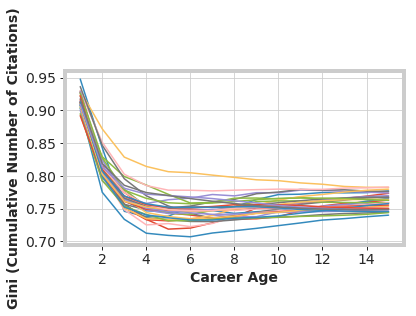

plot_cohort_size_gini_cor ---  unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


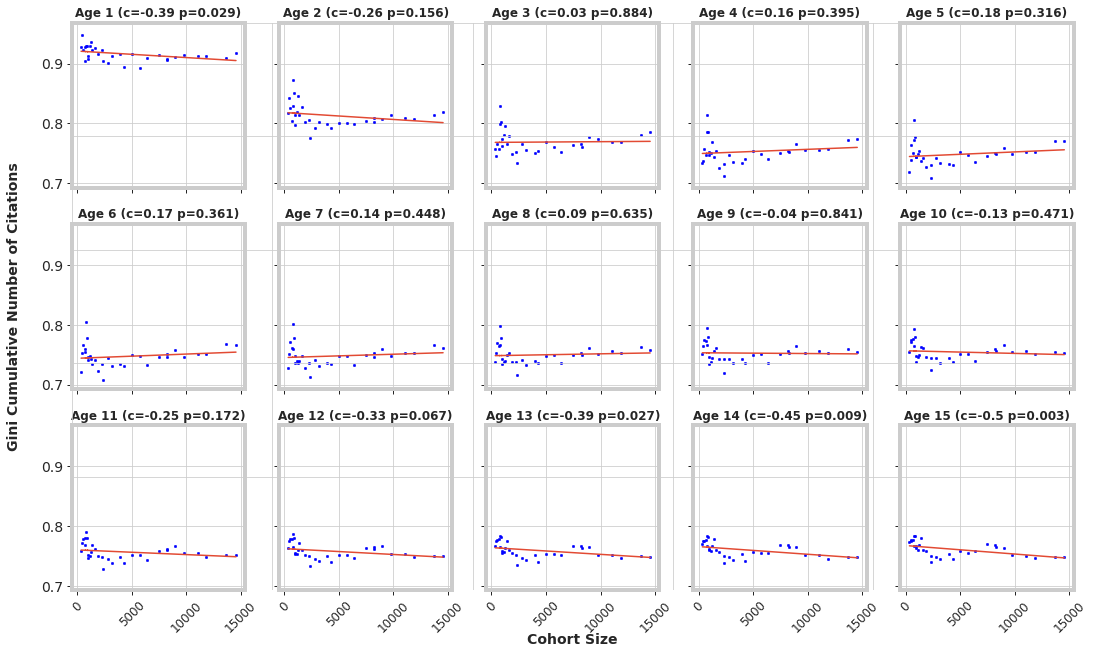

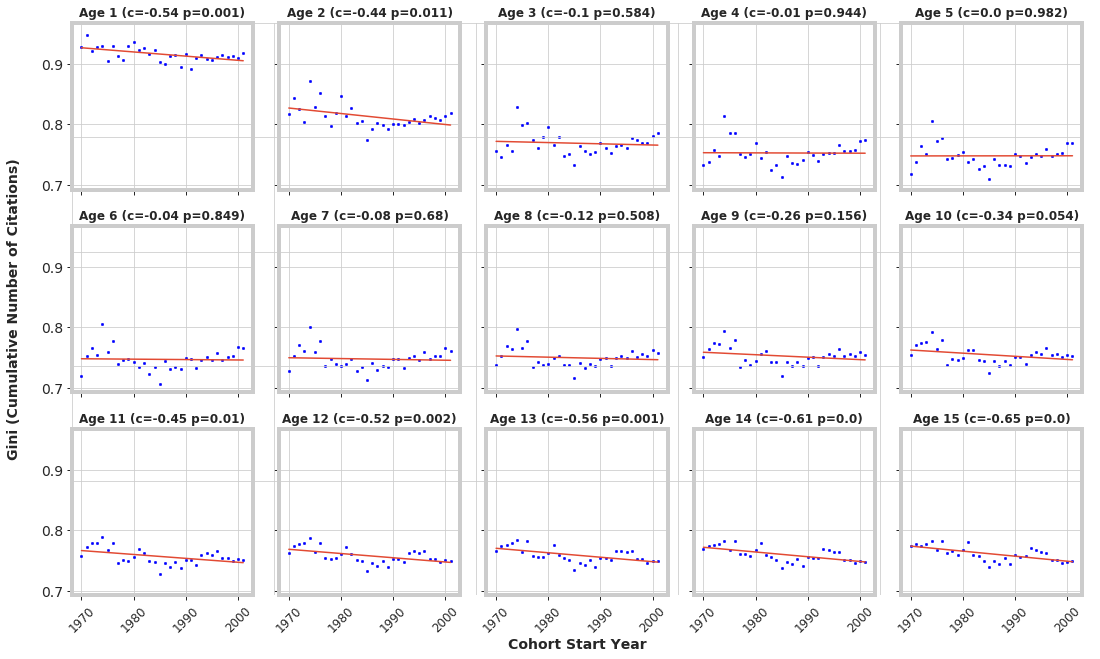

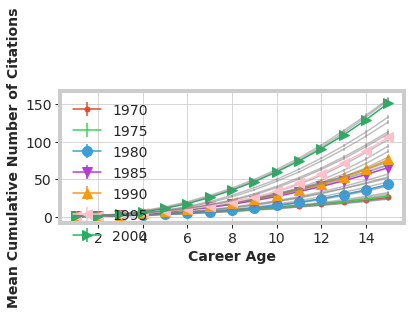

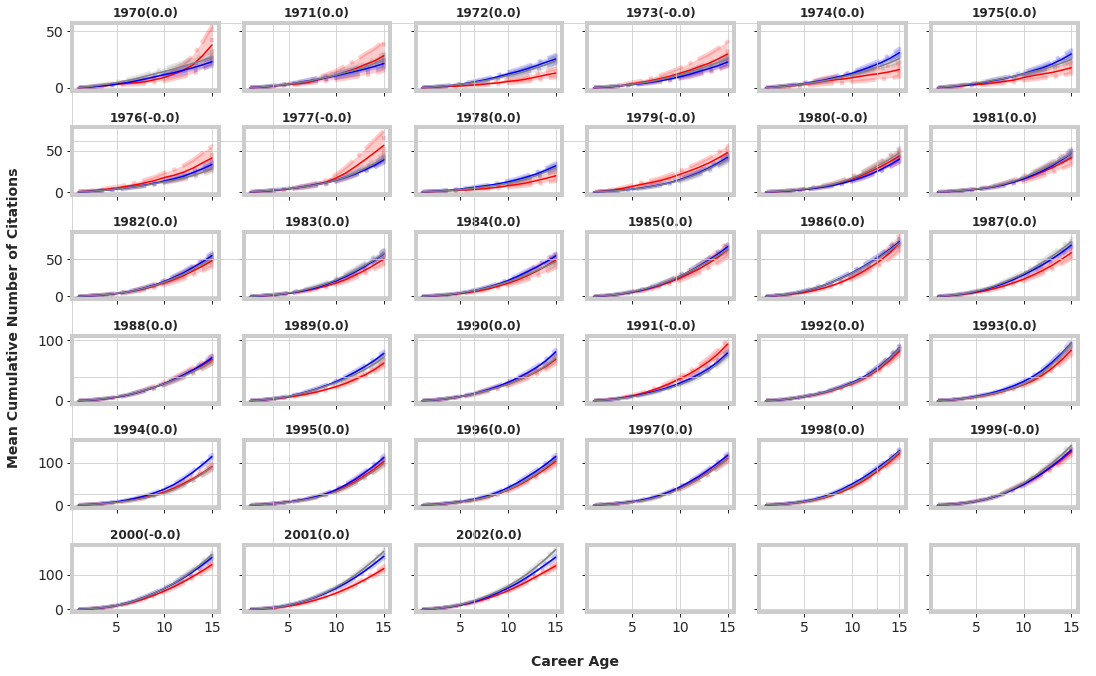

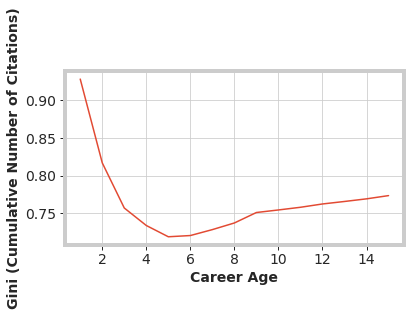

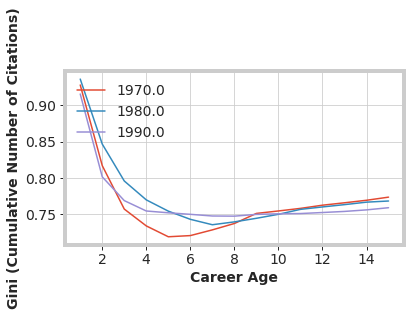

In [41]:

plot.run_cohort_analysis(groupByYearData, cohort_start_years, 
                         MAX_CAREER_LENGTH_COHORT, "cum_num_cit", "Cumulative Number of Citations", authorStartEndCareerData)  

# What should i do with the rest of this notebook?

### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

In [42]:
# cohort_start_years = [1974, 1975, 1976, 1979, 2000]

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')

# cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'cum_num_cit')
# plot.plot_cumulative_dist(cohort_careerage_df, 1, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 5, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'cum_num_cit', 'Cumulative Number of Citations')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'cum_num_cit', 'Cumulative Number of Citations')

### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [43]:
# _1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1975] 
# _1985Authors.shape

In [44]:
# _1985Authors.columns

In [45]:
# _1985Authors.sort_values(by=['num_cit'], axis = 0, ascending=False,inplace=False)

In [46]:
# _1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
# _1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
# print(_1995_2000_year_1985Authors.shape)
# _1995_2000_year_1985Authors.head(10)

In [47]:
# temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
# temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
# temp.head()

# #print(temp1['id2'].unique())

In [48]:
# donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
# donatella

In [49]:
# plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [50]:
# authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [51]:
#just for debugging
reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

<module 'plot' from '/home/danielkostic/cumulative-advantage/plot.py'>

In [52]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [53]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [54]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)